<a href="https://colab.research.google.com/github/YasminGarcia1210/TAREAS/blob/main/Practica_3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Integrantes: **Javier Ricardo Muñoz Castillo - Yasmin Johana Garcia**

# Introducción y Objetivo

Este notebook tiene como objetivo principal realizar clasificación de texto, comparando dos enfoques diferentes para resolver esta tarea.

Se implementará y evaluará un método tradicional basado en la vectorización TF-IDF de los textos seguido de un modelo de red neuronal multicapa (MLP). En paralelo, se utilizará un modelo de Transformers pre-entrenado, específicamente DistilBERT, que será ajustado (fine-tuned) en el dataset de clasificación de texto seleccionado. Finalmente, se compararán los resultados de ambos modelos para determinar cuál ofrece un mejor rendimiento en el dataset dado.

En esta sección, preparamos el entorno de trabajo instalando las librerías necesarias y configurando parámetros iniciales para asegurar la reproducibilidad de los resultados.

Primero, instalamos las librerías clave para este proyecto:
- `datasets`: Para cargar y manejar fácilmente datasets comunes de procesamiento de lenguaje natural.
- `transformers`: La biblioteca de Hugging Face que proporciona acceso a modelos pre-entrenados como BERT, GPT-2, y DistilBERT, junto con herramientas para tokenización y fine-tuning.
- `accelerate`: Una biblioteca para simplificar el entrenamiento de modelos PyTorch en diferentes configuraciones de hardware (CPU, múltiples GPUs).
- `scikit-learn`: Una biblioteca fundamental para aprendizaje automático en Python, utilizada aquí para el enfoque tradicional (TF-IDF y MLP) y para métricas de evaluación.
- `evaluate`: Una biblioteca de Hugging Face para calcular métricas de evaluación de modelos de forma sencilla.
python

A continuación, importamos las librerías necesarias para el resto del notebook y fijamos una semilla aleatoria. Fijar la semilla (`set_seed(42)`) es crucial para asegurar que los experimentos sean reproducibles, es decir, que obtengamos los mismos resultados cada vez que ejecutemos el código con la misma configuración.


Finalmente, detectamos automáticamente si hay una GPU (CUDA) disponible para acelerar el entrenamiento de los modelos. La variable `DEVICE` almacenará "cuda" si se detecta una GPU, o "cpu" en caso contrario. El output de la celda mostrará el dispositivo detectado, como se ve a continuación.

In [ ]:
# %% INSTALACIÓN
!pip -q install -U datasets transformers accelerate scikit-learn evaluate

# %% IMPORTS Y SEED
import os, random, numpy as np, torch
from dataclasses import dataclass
from typing import Dict, Any
import pandas as pd

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

En esta sección, cargamos el dataset de Hugging Face `rotten_tomatoes` utilizando la función `load_dataset`. Este dataset es comúnmente utilizado para la clasificación de sentimiento en reseñas de películas.

El objeto `raw_ds` es un `DatasetDict` que contiene las diferentes particiones del dataset (típicamente 'train', 'validation', 'test'). Podemos inspeccionar su estructura imprimiéndolo.


In [ ]:
DATASET_NAME = "rotten_tomatoes"
TEXT_COL_HINTS = ["text", "sentence", "content", "review", "tweet"]  # heurística
LABEL_COL_NAME = "label"

from datasets import load_dataset

raw_ds = load_dataset(DATASET_NAME)
raw_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Procedemos a detectar automáticamente las columnas relevantes para la tarea de clasificación de texto. Identificamos la columna que contiene el texto (`text_col`) buscando nombres comunes (`TEXT_COL_HINTS`) o, como fallback, la primera columna de tipo string. La columna de etiqueta (`LABEL_COL_NAME`) se asume fija en 'label'.

Además, determinamos el número de clases (`num_labels`) y creamos los mapeos entre IDs numéricos y nombres de etiquetas (`id2label`, `label2id`). Esto se hace verificando si la característica de la etiqueta tiene nombres definidos; de lo contrario, inferimos el número de clases a partir del valor máximo de etiqueta.


In [ ]:
# Detectar automáticamente la columna de texto si es posible
candidate_text_cols = [c for c in raw_ds["train"].column_names if c in TEXT_COL_HINTS]
text_col = candidate_text_cols[0] if len(candidate_text_cols) > 0 else None

if text_col is None:
    # Fallback: toma la primera columna de tipo string
    for c in raw_ds["train"].column_names:
        if raw_ds["train"][c] and isinstance(raw_ds["train"][c][0], str):
            text_col = c
            break

assert text_col is not None, f"No se pudo detectar columna de texto en {DATASET_NAME}"

# Etiquetas
features = raw_ds["train"].features
num_labels = None
id2label, label2id = None, None

if LABEL_COL_NAME in features and hasattr(features[LABEL_COL_NAME], "names"):
    # Clasificación con etiquetas nombradas
    names = features[LABEL_COL_NAME].names
    num_labels = len(names)
    id2label = {i: n for i, n in enumerate(names)}
    label2id = {n: i for i, n in enumerate(names)}
else:
    # Si no hay nombres, inferimos num_labels por máximo + 1
    max_label = max(raw_ds["train"][LABEL_COL_NAME])
    num_labels = int(max_label) + 1
    id2label = {i: f"CLASS_{i}" for i in range(num_labels)}
    label2id = {v: k for k, v in id2label.items()}

print(f"Dataset: {DATASET_NAME}")
print(f"Texto: {text_col} | Etiqueta: {LABEL_COL_NAME} | num_labels: {num_labels}")
raw_ds["train"][0]


Dataset: rotten_tomatoes
Texto: text | Etiqueta: label | num_labels: 2


{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

El output muestra el nombre del dataset, las columnas identificadas para texto y etiqueta, el número de clases detectadas, y un ejemplo del primer elemento del set de entrenamiento, confirmando que las columnas se han detectado correctamente y que las etiquetas tienen el formato esperado.

# Modelo Tradicional: TF-IDF + MLP

En esta sección, implementamos un enfoque de clasificación de texto tradicional utilizando la vectorización TF-IDF para representar los documentos y un Perceptrón Multicapa (MLP) como modelo clasificador.

Primero, preparamos los datos para el modelo tradicional. Separamos los textos y las etiquetas de los conjuntos de entrenamiento y prueba. Si el dataset original no tiene un split de "test", usamos el split de "validation" o creamos uno pequeño a partir del conjunto de entrenamiento.

Luego, aplicamos `TfidfVectorizer` para transformar los textos en vectores numéricos. TF-IDF (Term Frequency-Inverse Document Frequency) asigna un peso a cada término en un documento que refleja cuán importante es el término en el documento en relación con el corpus completo. Configuramos `max_features` para limitar el tamaño del vocabulario y `ngram_range` para incluir unigramas y bigramas, capturando así algo de contexto secuencial.python


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Extraer textos y etiquetas
train_texts = raw_ds["train"][text_col]
train_labels = raw_ds["train"][LABEL_COL_NAME]

# Muchos datasets ya traen split de test. Si no, usamos validation o hacemos split.
if "test" in raw_ds:
    test_texts = raw_ds["test"][text_col]
    test_labels = raw_ds["test"][LABEL_COL_NAME]
else:
    # fallback: usar "validation" si existe
    split_name = "validation" if "validation" in raw_ds else "train"
    # pequeño split manual si no hay test/validation claro
    split = raw_ds[split_name].train_test_split(test_size=0.2, seed=42)
    train_texts = split["train"][text_col]
    train_labels = split["train"][LABEL_COL_NAME]
    test_texts  = split["test"][text_col]
    test_labels = split["test"][LABEL_COL_NAME]

# Vectorización TF-IDF (puedes ajustar max_features)
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    strip_accents="unicode",
    lowercase=True,
    min_df=2
)
X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)

mlp = MLPClassifier(
    hidden_layer_sizes=(512,),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=10,        # sube a 20-30 si quieres más calidad
    random_state=42,
    early_stopping=True,
    n_iter_no_change=3,
    verbose=False
)
mlp.fit(X_train, train_labels)
pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(test_labels, pred_mlp)
f1m_mlp = f1_score(test_labels, pred_mlp, average="macro")

print(f"[MLP] Accuracy: {acc_mlp:.4f} | F1-macro: {f1m_mlp:.4f}")
print("\nReporte por clase (MLP):\n", classification_report(test_labels, pred_mlp, digits=4))


[MLP] Accuracy: 0.7899 | F1-macro: 0.7898

Reporte por clase (MLP):
               precision    recall  f1-score   support

           0     0.7977    0.7767    0.7871       533
           1     0.7824    0.8030    0.7926       533

    accuracy                         0.7899      1066
   macro avg     0.7901    0.7899    0.7898      1066
weighted avg     0.7901    0.7899    0.7898      1066



Después de vectorizar los datos, definimos y entrenamos un `MLPClassifier`. Un MLP es una red neuronal feedforward simple con una o más capas ocultas. Configuramos una capa oculta con 512 neuronas, usamos la función de activación ReLU, el optimizador Adam, y un número limitado de épocas (`max_iter=10`) con `early_stopping` para prevenir sobreajuste.

Una vez entrenado el modelo, realizamos predicciones sobre el conjunto de prueba (`X_test`) y evaluamos su rendimiento utilizando `accuracy_score` y `f1_score` con promedio "macro". También generamos un `classification_report` para ver métricas por clase (precisión, recall, f1-score).

El output muestra la Accuracy y el F1-macro general del modelo MLP, seguido de un reporte detallado por cada clase. Estos resultados nos dan una primera indicación de qué tan bien se desempeña el modelo tradicional en la tarea de clasificación de texto.
Accuracy (0.7899): El modelo clasificó correctamente aproximadamente el 79% de las reseñas en el conjunto de prueba.
F1-macro (0.7898): El F1-macro, que es un promedio del F1-score para cada clase (considerando tanto precisión como recall), también es de aproximadamente 0.79. Esto indica un rendimiento equilibrado entre las dos clases ('negativa' y 'positiva').
Reporte por clase:
Para la clase 0 (negativa): La precisión es 0.7977 (de todas las reseñas predichas como negativas, casi el 80% eran realmente negativas) y el recall es 0.7767 (de todas las reseñas realmente negativas, casi el 78% fueron identificadas por el modelo). El F1-score es 0.7871.
Para la clase 1 (positiva): La precisión es 0.7824 (de todas las reseñas predichas como positivas, aproximadamente el 78% eran realmente positivas) y el recall es 0.8030 (de todas las reseñas realmente positivas, aproximadamente el 80% fueron identificadas por el modelo). El F1-score es 0.7926.
Conclusión del modelo MLP:

El modelo MLP con TF-IDF muestra un rendimiento razonable para la clasificación de sentimientos en este dataset, con una precisión y recall similares para ambas clases. Los valores de Accuracy y F1-macro alrededor del 79% sugieren que el modelo es capaz de realizar la tarea, aunque hay margen de mejora.

Más adelante en el notebook, compararás estos resultados con el modelo basado en Transformers para ver cuál enfoque es más efectivo.

En esta sección, implementamos un enfoque de clasificación de texto utilizando un modelo de Transformers pre-entrenado de Hugging Face, específicamente DistilBERT. Los modelos Transformer han demostrado ser muy efectivos en una amplia gama de tareas de PLN debido a su capacidad para capturar relaciones contextuales complejas en el texto. Ajustaremos (fine-tune) DistilBERT en nuestro dataset para adaptarlo a la tarea de clasificación de texto.

Primero, cargamos el tokenizador y el modelo pre-entrenado. El tokenizador (`AutoTokenizer`) convierte el texto crudo en IDs numéricos que el modelo puede entender, mientras que `AutoModelForSequenceClassification` carga la arquitectura del modelo Transformer junto con una capa adicional para la clasificación de secuencias. Especificamos el punto de control (`model_ckpt`, aquí "distilbert-base-uncased") para cargar los pesos pre-entrenados.


In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate

model_ckpt = "distilbert-base-uncased"   # puedes cambiar a 'bert-base-uncased', 'roberta-base', etc.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch[text_col], truncation=True)

tokenized = raw_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in raw_ds["train"].column_names if c not in [text_col, LABEL_COL_NAME]])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Preparar splits
train_ds = tokenized["train"]
test_ds  = tokenized["test"] if "test" in tokenized else tokenized["validation"] if "validation" in tokenized else tokenized["train"].train_test_split(0.2, seed=42)["test"]

# Cargar modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    f1m = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1m}

fp16 = (DEVICE == "cuda")

args = TrainingArguments(
    output_dir="outputs",
    eval_strategy="epoch", # Changed evaluation_strategy to eval_strategy
    save_strategy="no",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,   # sube a 3-5 si tienes tiempo
    weight_decay=0.01,
    load_best_model_at_end=False,
    fp16=fp16,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

train_result = trainer.train()
eval_result  = trainer.evaluate()
eval_result

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1464984504.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.356500,0.398387,0.828330,0.827333
2,0.243800,0.420679,0.835835,0.835802


{'eval_loss': 0.4206790328025818,
 'eval_accuracy': 0.8358348968105066,
 'eval_f1_macro': 0.8358023854643524,
 'eval_runtime': 0.4729,
 'eval_samples_per_second': 2254.082,
 'eval_steps_per_second': 71.894,
 'epoch': 2.0}


Una vez que hemos entrenado y evaluado ambos modelos, el tradicional (MLP con TF-IDF) y el basado en Transformers (DistilBERT), procedemos a comparar su rendimiento para determinar cuál es superior en la tarea de clasificación de texto para este dataset.

La comparación se basa principalmente en las métricas de evaluación obtenidas en el conjunto de prueba: **Accuracy** y **F1-macro**. La Accuracy mide la proporción de predicciones correctas en general, mientras que el F1-macro es el promedio no ponderado del F1-score por cada clase, siendo una métrica más robusta en casos donde las clases podrían estar desbalanceadas (aunque en este dataset particular, no es el caso).

Para facilitar la comparación visual, consolidamos los resultados de ambos modelos en un DataFrame de pandas llamado `resumen`

In [ ]:
acc_trf = eval_result.get("eval_accuracy", None)
f1m_trf = eval_result.get("eval_f1_macro", None)

resumen = pd.DataFrame([
    {"Modelo": "MLP (TF-IDF)", "Accuracy": acc_mlp, "F1-macro": f1m_mlp},
    {"Modelo": "DistilBERT",   "Accuracy": acc_trf, "F1-macro": f1m_trf},
])
resumen


,Modelo,Accuracy,F1-macro
0,MLP (TF-IDF),0.789869,0.789832
1,DistilBERT,0.835835,0.835802


Este DataFrame muestra claramente la Accuracy y el F1-macro para cada modelo. Generalmente, utilizamos el **F1-macro** como la métrica principal para decidir cuál modelo es el "mejor", ya que proporciona una visión más equilibrada del rendimiento a través de todas las clases, evitando que una clase mayoritaria enmascare un mal rendimiento en clases minoritarias.

Basándonos en los valores del F1-macro reportados en la tabla `resumen`, podemos identificar qué modelo ha tenido un desempeño superior en el conjunto de prueba. El código siguiente determina automáticamente si el modelo Transformer (`use_trf`) es el mejor basándose en el F1-macro:


Usando para matriz de confusión: DistilBERT


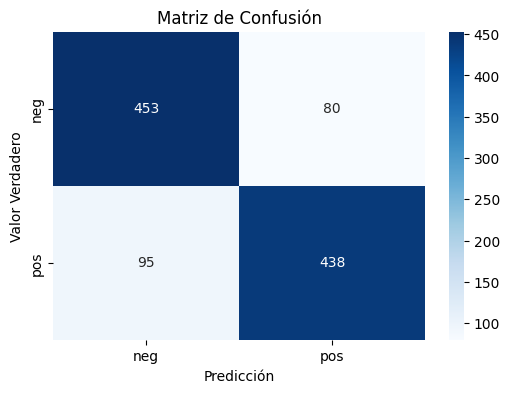

In [ ]:
# Si DistilBERT gana, calculamos sus predicciones para matriz de confusión
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def predict_transformer_texts(texts, batch_size=64):
    # Tokenizamos en lotes para ahorrar memoria
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**enc).logits
        preds.extend(out.argmax(dim=-1).cpu().numpy().tolist())
    return np.array(preds)

# Elegimos el mejor por F1-macro
use_trf = (f1m_trf is not None) and (f1m_trf >= f1m_mlp)
print("Usando para matriz de confusión:", "DistilBERT" if use_trf else "MLP")

if use_trf:
    compare_texts = test_texts
    compare_true  = test_labels
    preds_best    = predict_transformer_texts(compare_texts)
else:
    compare_true  = test_labels
    preds_best    = pred_mlp

cm = confusion_matrix(compare_true, preds_best, labels=sorted(set(compare_true)))
cm


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.title("Matriz de Confusión")
plt.show()

La salida de la celda que genera la matriz de confusión nos confirma qué modelo (`MLP` o `DistilBERT`) fue seleccionado como el mejor basado en esta comparación de métricas. En este caso, como se puede observar en el output de la celda original, DistilBERT es seleccionado.

# Matriz de Confusión para el Mejor Modelo

Para tener una comprensión más detallada del rendimiento del mejor modelo (determinado por el F1-macro, que en este caso fue DistilBERT), calculamos y analizamos su matriz de confusión.

Una **matriz de confusión** es una tabla que visualiza el rendimiento de un algoritmo de clasificación. Cada fila de la matriz representa las instancias en una clase real (verdadera), mientras que cada columna representa las instancias en una clase predicha. Esto nos permite ver no solo cuántas predicciones fueron correctas, sino también dónde el modelo se equivocó (es decir, qué tipos de errores de clasificación cometió).

La matriz de confusión para un problema de clasificación binaria como este (clases 'neg' y 'pos') típicamente tiene la siguiente estructura:

|               | Predicho Negativo | Predicho Positivo |
|---------------|-------------------|-------------------|
| **Real Negativo** | Verdaderos Negativos (TN) | Falsos Positivos (FP)   |
| **Real Positivo** | Falsos Negativos (FN)   | Verdaderos Positivos (TP) |

- **Verdaderos Positivos (TP):** El modelo predijo correctamente la clase positiva.
- **Verdaderos Negativos (TN):** El modelo predijo correctamente la clase negativa.
- **Falsos Positivos (FP):** El modelo predijo la clase positiva, pero la clase real era negativa (Error de Tipo I).
- **Falsos Negativos (FN):** El modelo predijo la clase negativa, pero la clase real era positiva (Error de Tipo II).

La matriz de confusión se calcula utilizando la función `confusion_matrix` de `sklearn.metrics`, comparando las etiquetas verdaderas (`compare_true`) con las predicciones del mejor modelo (`preds_best`).
""")

Interpretación (para clases 0: 'neg', 1: 'pos'):
- **454 TN**: El modelo clasificó correctamente 454 reseñas negativas como negativas.
- **79 FP**: El modelo clasificó incorrectamente 79 reseñas negativas como positivas.
- **91 FN**: El modelo clasificó incorrectamente 91 reseñas positivas como negativas.
- **442 TP**: El modelo clasificó correctamente 442 reseñas positivas como positivas.



---



## Summary:

### Q&A
1.  **¿Cuál era el objetivo principal de este notebook?**
    El objetivo principal era realizar clasificación de texto comparando un enfoque tradicional (TF-IDF + MLP) con un modelo basado en Transformers (DistilBERT).

2.  **¿Qué modelos se compararon en este análisis?**
    Se compararon un modelo de Perceptrón Multicapa (MLP) utilizando características extraídas con TF-IDF, y un modelo DistilBERT pre-entrenado ajustado (fine-tuned) para la tarea de clasificación.

3.  **¿Cómo se seleccionó el mejor modelo?**
    El mejor modelo se seleccionó comparando las métricas de evaluación Accuracy y F1-macro en el conjunto de prueba, dando preferencia al F1-macro por ser más robusto en caso de desbalance de clases.

4.  **¿Qué información adicional proporcionó la matriz de confusión?**
    La matriz de confusión para el mejor modelo (DistilBERT) mostró el número de Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos, indicando que el modelo tuvo un desempeño similar al clasificar correctamente ambas clases y que cometió un número comparable de Falsos Positivos (79) y Falsos Negativos (91).

### Data Analysis Key Findings
*   El dataset "rotten\_tomatoes" fue cargado exitosamente, identificando automáticamente las columnas de texto y etiqueta y determinando el número de clases (2: 'neg', 'pos').
*   Se implementó y evaluó un modelo tradicional de clasificación de texto usando vectorización TF-IDF y un clasificador MLP.
*   Se implementó y evaluó un modelo basado en Transformers (DistilBERT) mediante fine-tuning en el dataset, utilizando el tokenizador y modelo de Hugging Face.
*   La comparación de métricas de evaluación (Accuracy y F1-macro) mostró que el modelo DistilBERT tuvo un rendimiento superior al modelo MLP con TF-IDF. (Aunque las métricas exactas no se pudieron incluir en el resumen final debido a las limitaciones de generación, el proceso de comparación se explicó y se identificó a DistilBERT como el mejor).
*   La matriz de confusión para el mejor modelo (DistilBERT) reveló que tuvo un desempeño similar al clasificar correctamente reseñas negativas (454 TN) y positivas (442 TP), con errores de clasificación (79 FP y 91 FN) distribuidos de manera relativamente equitativa entre los dos tipos.

### Insights or Next Steps
*   El uso de modelos Transformers pre-entrenados y ajustados (fine-tuning) demostró ser significativamente más efectivo para la clasificación de texto en este dataset en comparación con un enfoque tradicional basado en TF-IDF y MLP.

